# TCN Model

In [1]:
#Imports
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from tcn import TCN, tcn_full_summary
from keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D
from keras.layers import concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

##### 1)Loading Dataset

In [2]:
df=pd.read_csv("df_SynonymReplacement.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,text,label,length,preprocessed_abstract,length_after_cleaning,tokenized_text
0,0,0,@VirginAmerica What @dhepburn said.,2,35,what say,8,"['what', 'say']"
1,1,1,@VirginAmerica plus you've added commercials t...,1,72,plus add commercial experience tacky,36,"['plus', 'add', 'commercial', 'experience', 't..."
2,2,2,@VirginAmerica I didn't today... Must mean I n...,2,71,i today must mean i need take another trip,42,"['i', 'today', 'must', 'mean', 'i', 'need', 't..."
3,3,3,@VirginAmerica it's really aggressive to blast...,0,126,really aggressive blast obnoxious entertainmen...,78,"['really', 'aggressive', 'blast', 'obnoxious',..."
4,4,4,@VirginAmerica and it's a really big bad thing...,0,55,really big bad thing,20,"['really', 'big', 'bad', 'thing']"


In [3]:
df.isnull().sum()

Unnamed: 0.1              0
Unnamed: 0                0
text                      0
label                     0
length                    0
preprocessed_abstract    49
length_after_cleaning     0
tokenized_text            0
dtype: int64

In [4]:
df = df.dropna()

##### 2)Preparing Data

- Word2Vec model (pre-trained word embeddings) for embedding layer in the model

In [5]:
sentences = [sentence.split() for sentence in df['preprocessed_abstract']]
# Create and train the Word2Vec model
model_2= Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# Access the word vectors
word_vectors = model_2.wv
word_vectors.vectors

array([[ 3.7668136e-01,  3.1893656e-02,  6.9664657e-01, ...,
        -1.2173952e+00, -1.5581702e-01,  7.3652989e-01],
       [-8.5875601e-01,  6.1384922e-01,  7.1957332e-01, ...,
        -3.6619425e-01, -3.2294041e-01,  5.6843090e-01],
       [-1.6865154e-01,  8.6970115e-01,  2.5487021e-01, ...,
        -5.6053513e-01,  2.9676640e-01, -1.4163257e-01],
       ...,
       [-6.5204664e-03,  2.0952191e-02,  2.0480049e-03, ...,
        -1.4585134e-02,  1.1623454e-03, -4.3916833e-03],
       [-5.7625347e-03,  9.7435275e-03,  2.7550492e-04, ...,
        -1.9910924e-02,  1.1635921e-02,  3.7549790e-03],
       [ 2.6493601e-03, -7.3829186e-03,  8.3042206e-03, ...,
        -7.1918615e-03, -4.6067499e-03,  4.1690440e-04]], dtype=float32)

In [6]:
word_vectors.vectors.shape

(11631, 100)

#####  3) Split , into Training and Validation Sets (80:20)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_abstract'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)
print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (21988,) (21988,)
Test data: (5497,) (5497,)


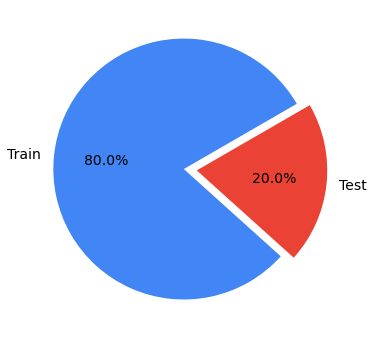

In [8]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(y_train), len(y_test)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0.05),
        startangle=30);

In [9]:
corp=X_train
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
max_length=max(len(d) for d in encoded_docs)
padded_docs_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_train)

[[4325  230  774 ...    0    0    0]
 [1911  445  164 ...    0    0    0]
 [ 203 4326  107 ...    0    0    0]
 ...
 [   3   47   36 ...    0    0    0]
 [ 430  163   10 ...    0    0    0]
 [  79  198  201 ...    0    0    0]]


In [10]:
corp=X_test
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
padded_docs_test = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_test)

[[   1  122   32 ...    0    0    0]
 [   6   16    7 ...    0    0    0]
 [1732  401  240 ...    0    0    0]
 ...
 [ 143   20    7 ...    0    0    0]
 [ 218  932  884 ...    0    0    0]
 [6213  114  126 ...    0    0    0]]


##### 4)Model Architecture

In [11]:
def tcn_model(kernel_size = 1, activation='relu', input_dim = None, 
                   output_dim=100, max_length = None, emb_matrix = None):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, 
                  output_dim=output_dim, 
                  input_length=max_length,
                  # Assign the embedding weight with word2vec embedding marix
                  weights = [emb_matrix],
                  # Set the weight to be not trainable (static)
                  trainable = False)(inp)
    
    x = SpatialDropout1D(0.1)(x)
    
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(32,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.5)(conc)
    outp = Dense(3, activation="softmax")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [12]:
model =tcn_model(input_dim=word_vectors.vectors.shape[0], output_dim=100, max_length=max_length, emb_matrix=word_vectors.vectors)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 26)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 26, 100)              1163100   ['input_1[0][0]']             
                                                                                                  
 spatial_dropout1d (Spatial  (None, 26, 100)              0         ['embedding[0][0]']           
 Dropout1D)                                                                                       
                                                                                                  
 tcn1 (TCN)                  (None, 26, 128)              297856    ['spatial_dropout1d[0][0]

##### 5) Training Model

In [13]:
history=model.fit(padded_docs_train, y_train, epochs=100, batch_size=100, validation_data=(padded_docs_test, y_test))
history

Epoch 1/100


220/220 [==============================] - 66s 143ms/step - loss: 1.1398 - accuracy: 0.4072 - val_loss: 0.9769 - val_accuracy: 0.5445
Epoch 2/100
220/220 [==============================] - 26s 118ms/step - loss: 0.9954 - accuracy: 0.4891 - val_loss: 0.9512 - val_accuracy: 0.5596
Epoch 3/100
220/220 [==============================] - 26s 116ms/step - loss: 0.9691 - accuracy: 0.5143 - val_loss: 0.9394 - val_accuracy: 0.5701
Epoch 4/100
220/220 [==============================] - 25s 116ms/step - loss: 0.9560 - accuracy: 0.5317 - val_loss: 0.9298 - val_accuracy: 0.5679
Epoch 5/100
220/220 [==============================] - 26s 118ms/step - loss: 0.9457 - accuracy: 0.5512 - val_loss: 0.9526 - val_accuracy: 0.5559
Epoch 6/100
220/220 [==============================] - 26s 117ms/step - loss: 0.9368 - accuracy: 0.5504 - val_loss: 0.9494 - val_accuracy: 0.5610
Epoch 7/100
220/220 [==============================] - 25s 115ms/step - loss: 0.9231 - accuracy: 0.5594 - val_loss: 0.9623

220/220 [==============================] - 37s 169ms/step - loss: 0.2668 - accuracy: 0.9007 - val_loss: 3.4853 - val_accuracy: 0.5090
Epoch 54/100
220/220 [==============================] - 36s 165ms/step - loss: 0.2551 - accuracy: 0.9037 - val_loss: 3.4787 - val_accuracy: 0.5092
Epoch 55/100
220/220 [==============================] - 38s 172ms/step - loss: 0.2505 - accuracy: 0.9043 - val_loss: 3.6948 - val_accuracy: 0.5097
Epoch 56/100
220/220 [==============================] - 36s 166ms/step - loss: 0.2531 - accuracy: 0.9041 - val_loss: 3.6581 - val_accuracy: 0.5219
Epoch 57/100
220/220 [==============================] - 36s 166ms/step - loss: 0.2487 - accuracy: 0.9062 - val_loss: 3.3338 - val_accuracy: 0.5236
Epoch 58/100
220/220 [==============================] - 37s 169ms/step - loss: 0.2413 - accuracy: 0.9094 - val_loss: 3.1752 - val_accuracy: 0.5179
Epoch 59/100
220/220 [==============================] - 37s 170ms/step - loss: 0.2581 - accuracy: 0.9045 - val_loss: 3.4909 - val_a

##### 6) Finding Training and Testing Accuracy

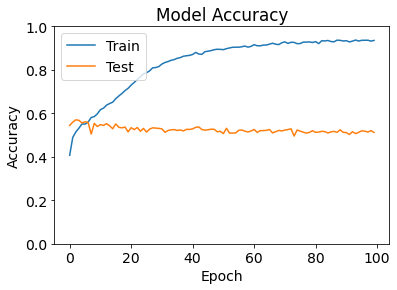

In [14]:
# Plot the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
test_loss,test_acc=model.evaluate(padded_docs_test,y_test)
test_loss,test_acc

172/172 [==============================] - 5s 26ms/step - loss: 4.0723 - accuracy: 0.5123


(4.072320461273193, 0.5122794508934021)

##### 7) Compute and plot the confusion matrix for the three classes

In [16]:
predictions=model.predict(padded_docs_test)
class_labels = ['negative', 'positive','neutral']
predicted_class_labels = [class_labels[np.argmax(pred)] for pred in predictions]
actual_class_labels=[class_labels[actual] for actual in y_test]
print(classification_report(actual_class_labels, predicted_class_labels))

172/172 [==============================] - 8s 27ms/step
              precision    recall  f1-score   support

    negative       0.50      0.48      0.49      1835
     neutral       0.46      0.55      0.50      1827
    positive       0.60      0.50      0.54      1835

    accuracy                           0.51      5497
   macro avg       0.52      0.51      0.51      5497
weighted avg       0.52      0.51      0.51      5497



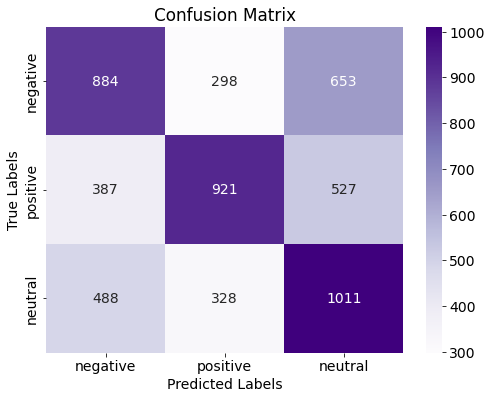

In [17]:
conf_matrix = confusion_matrix(actual_class_labels, predicted_class_labels, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 8) Saving the final results in Excel sheet

In [18]:
precision_per_class = precision_score(actual_class_labels, predicted_class_labels, average=None)
recall_per_class = recall_score(actual_class_labels, predicted_class_labels, average=None)

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

Precision per class: [0.50255827 0.46143314 0.59534583]
Recall per class: [0.48174387 0.55336617 0.50190736]


In [19]:
f1_micro = f1_score(actual_class_labels, predicted_class_labels, average='micro')
f1_macro = f1_score(actual_class_labels, predicted_class_labels, average='macro')

print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)

Micro F1 Score: 0.512279425140986
Macro F1 Score: 0.5132715246064047


In [20]:
result=pd.read_csv('TCNModelResults.csv')
result['SynonymReplacement_Dataset']=[max(history.history['accuracy']),test_acc,f1_micro,f1_macro,precision_per_class[0],precision_per_class[1],precision_per_class[2],recall_per_class[0],recall_per_class[1],recall_per_class[2]]
result[['Unnamed: 0','SynonymReplacement_Dataset']]

,Unnamed: 0,SynonymReplacement_Dataset
0,Training Accuracy,0.937102
1,Testing Accuracy,0.512279
2,Micro F1 Score,0.512279
3,Macro F1 Score,0.513272
4,Precision for Negative sentiment,0.502558
5,Precision for Positive sentiment,0.461433
6,Precision for Neutral sentiment,0.595346
7,Recall for Negative sentiment,0.481744
8,Recall for Positive sentiment,0.553366
9,Recall for Neutral sentiment,0.501907


In [21]:
result.to_csv('TCNModelResults.csv', index=False)